# LightGBM Quickstart for the *American Express - Default Prediction* competition

This notebook shows how to apply LightGBM to the competition data, and it introduces a space-efficient way of feature engineering.

It is based on the [EDA which makes sense ⭐️⭐️⭐️⭐️⭐️](https://www.kaggle.com/code/ambrosm/amex-eda-which-makes-sense).

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats
import warnings
from colorama import Fore, Back, Style
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import CalibrationDisplay
from lightgbm import LGBMClassifier, log_evaluation

plt.rcParams['axes.facecolor'] = '#0057b8' # blue
plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'


In [53]:
###

INFERENCE = True # set to False if you only want to cross-validate

ONLY_FIRST_FOLD = False   ### WAS False

# FILL NAN VALUE
NAN_VALUE = -127 # will fit in int8

In [54]:
# @yunchonggan's fast metric implementation
# From https://www.kaggle.com/competitions/amex-default-prediction/discussion/328020
def amex_metric(y_true: np.array, y_pred: np.array) -> float:

    # count of positives and negatives
    n_pos = y_true.sum()
    n_neg = y_true.shape[0] - n_pos

    # sorting by descring prediction values
    indices = np.argsort(y_pred)[::-1]
    preds, target = y_pred[indices], y_true[indices]

    # filter the top 4% by cumulative row weights
    weight = 20.0 - target * 19.0
    cum_norm_weight = (weight / weight.sum()).cumsum()
    four_pct_filter = cum_norm_weight <= 0.04

    # default rate captured at 4%
    d = target[four_pct_filter].sum() / n_pos

    # weighted gini coefficient
    lorentz = (target / n_pos).cumsum()
    gini = ((lorentz - cum_norm_weight) * weight).sum()

    # max weighted gini coefficient
    gini_max = 10 * n_neg * (1 - 19 / (n_pos + 20 * n_neg))

    # normalized weighted gini coefficient
    g = gini / gini_max

    return 0.5 * (g + d)

def lgb_amex_metric(y_true, y_pred):
    """The competition metric with lightgbm's calling convention"""
    return ('amex',
            amex_metric(y_true, y_pred),
            True)

# Reading and preprocessing the data

We read the data from @raddar's [dataset](https://www.kaggle.com/datasets/raddar/amex-data-integer-dtypes-parquet-format). @raddar has [denoised the data](https://www.kaggle.com/competitions/amex-default-prediction/discussion/328514) so that we can achieve better results with his dataset than with the original competition csv files.

Then we create three groups of features:
- Selected features averaged over all statements of a customer
- The minimum or maximum of selected features over all statements of a customer
- Selected features taken from the last statement of a customer

The code has been optimized for memory efficiency rather than readability. In particular, `.iloc[mask_array, columns]` needs much less RAM than the groupby construction used in a previous version of the notebook.

Preprocessing for LightGBM is much simpler than for neural networks:
1. Neural networks can't process missing values; LightGBM handles them automatically.
1. Categorical features need to be one-hot encoded for neural networks; LightGBM handles them automatically.
1. With neural networks, you need to think about outliers; tree-based algorithms deal with outliers easily.
1. Neural networks need scaled inputs; tree-based algorithms don't depend on scaling.

In [55]:
### Added

from pyarrow.parquet import ParquetFile
import pyarrow as pa 

pf = ParquetFile(f'./input/amex-data-integer-dtypes-parquet-format/train.parquet') 
first_ten_rows = next(pf.iter_batches(batch_size = 10)) 
df = pa.Table.from_batches([first_ten_rows]).to_pandas() 

df.drop(columns=['customer_ID', 'S_2'], inplace=True)   ### These are not used in original code below
all_features = df.columns
print(str(len(all_features)))
print(str(all_features))

cat_cols=['Balance 30', 'Balance 38', 'Delinquency 63', 'Delinquency 64', 'Delinquency 66', 'Delinquency 68',
          'Delinquency 114', 'Delinquency 116', 'Delinquency 117', 'Delinquency 120', 'Delinquency 126', 'Target']
cols=[col for col in df.columns if (col.startswith(('B'))) & (col not in cat_cols[:-1])]
### DROP R_ cols TO SAVE RAM for this test
df.drop(columns=cols, inplace=True)

all_features = df.columns
print(str(len(all_features)))
print(str(all_features))

del pf,first_ten_rows,df
gc.collect()

188
Index(['P_2', 'D_39', 'B_1', 'B_2', 'R_1', 'S_3', 'D_41', 'B_3', 'D_42',
       'D_43',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=188)
148
Index(['P_2', 'D_39', 'R_1', 'S_3', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45',
       'R_2',
       ...
       'D_136', 'D_137', 'D_138', 'D_139', 'D_140', 'D_141', 'D_142', 'D_143',
       'D_144', 'D_145'],
      dtype='object', length=148)


33378

In [56]:
### ORIG
print('Original feature sets...')
features_avg = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_53', 'D_54', 'D_55', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_66', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_86', 'D_91', 'D_92', 'D_94', 'D_96', 'D_103', 'D_104', 'D_108', 'D_112', 'D_113', 'D_114', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_14', 'R_15', 'R_16', 'R_17', 'R_20', 'R_21', 'R_22', 'R_24', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_18', 'S_22', 'S_23', 'S_25', 'S_26']
features_min = ['B_2', 'B_4', 'B_5', 'B_9', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_20', 'B_28', 'B_29', 'B_33', 'B_36', 'B_42', 'D_39', 'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51', 'D_53', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 'D_71', 'D_74', 'D_75', 'D_78', 'D_83', 'D_102', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_128', 'D_132', 'D_140', 'D_141', 'D_144', 'D_145', 'P_2', 'P_3', 'R_1', 'R_27', 'S_3', 'S_5', 'S_7', 'S_9', 'S_11', 'S_12', 'S_23', 'S_25']
features_max = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_21', 'B_23', 'B_24', 'B_25', 'B_29', 'B_30', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_52', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_63', 'D_64', 'D_65', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_91', 'D_102', 'D_105', 'D_107', 'D_110', 'D_111', 'D_112', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_138', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_3', 'R_5', 'R_6', 'R_7', 'R_8', 'R_10', 'R_11', 'R_14', 'R_17', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']
features_last = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106', 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124', 'D_125', 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_19', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_16', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']
print(str(len(features_avg)))
print(str(len(features_min)))
print(str(len(features_max)))
print(str(len(features_last)))
print()

### REVISED
print('Revised features to be used: ')
features_to_use = features_last
# features_to_use = all_features
print(str(len(features_to_use)))
print(str(features_to_use))
print()

print('Revised features sets...')
features_avg = features_to_use
features_min = features_to_use
features_max = features_to_use
features_last = features_to_use
print(str(len(features_avg)))
print(str(len(features_min)))
print(str(len(features_max)))
print(str(len(features_last)))

Original feature sets...
140
63
124
142

Revised features to be used: 
142
['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106', 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124', 'D_125', 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_

In [57]:
### ADAPTED FROM ---> https://www.kaggle.com/code/glaskosk/xgboost-starter-0-793?scriptVersionId=101352220

def process_and_feature_engineer(df):
    # FEATURE ENGINEERING FROM 
    # https://www.kaggle.com/code/huseyincot/amex-agg-data-how-it-created
    all_cols = [c for c in list(df.columns) if c not in ['customer_ID','S_2']]
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    num_features = [col for col in all_cols if col not in cat_features]
    print(str(len(num_features)))

#     test_num_agg = df.groupby("customer_ID")[num_features].agg(['mean', 'std', 'min', 'max', 'last']) ### ORIG
    test_num_agg = df.groupby("customer_ID")[num_features].agg(['first','last','mean',  'median','std', 'min', 'max'])
    test_num_agg.columns = ['_'.join(x) for x in test_num_agg.columns]
#     test_num_agg.reset_index(inplace = True)
    
    # Lag Features
    for col in test_num_agg:
        if 'last' in col and col.replace('last', 'first') in test_num_agg:
#             test_num_agg[col + '_lag_sub'] = test_num_agg[col] - test_num_agg[col.replace('last', 'first')]
            test_num_agg[col + '_lag_div'] = test_num_agg[col] / (test_num_agg[col.replace('last', 'first')] + 0.000001)

#     test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique'])   ### ORIG
    ### TRY other options
    test_cat_agg = df.groupby("customer_ID")[cat_features].agg(['count', 'last', 'nunique', 'first']) ### TRY other options
    test_cat_agg.columns = ['_'.join(x) for x in test_cat_agg.columns]
#     test_cat_agg.reset_index(inplace = True)
    
#     test_new_agg = df.groupby("customer_ID")['B_30'].agg(['size'])
#     test_new_agg.columns = ['_'.join(x) for x in test_new_agg.columns]   

#     test_diff = get_difference(df, num_features)    
    
    df = pd.concat([test_num_agg, test_cat_agg], axis=1)   ### ORIG
    #df = cudf.concat([test_num_agg], axis=1)
    #df = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID')
    #df = cudf.test_num_agg

#     df = cudf.concat([test_num_agg, test_cat_agg, test_new_agg], axis=1)
#     df = test_num_agg.merge(test_cat_agg, how = 'inner', on = 'customer_ID').merge(train_diff, how = 'inner', on = 'customer_ID')
                            #.merge(train_labels, how = 'inner', on = 'customer_ID')
    
    del test_num_agg, test_cat_agg   ### ORIG
#     del test_num_agg, test_cat_agg, test_diff # test_new_agg,
    print('shape after engineering', df.shape )
    
    # ERR  df = df.replace([np.inf, -np.inf], 0,inplace=True).astype('float32')
    # ERR df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=1)
    # ERR df = df.replace([np.inf], np.nan, inplace=True)
    # ERR df = df.replace([np.inf], np.nan, inplace=True)
    df = df.fillna(NAN_VALUE) 
    return df

# train = process_and_feature_engineer(train)
# print(str(len(train)))
#train.P_2_last_lag_sub

In [58]:
%%time
for i in ['test', 'train'] if INFERENCE else ['train']:
    df = pd.read_parquet(f'./input/amex-data-integer-dtypes-parquet-format/{i}.parquet')
    
    ### Just keep select features (not enough ARAM for all features)
    cat_features = ["B_30","B_38","D_114","D_116","D_117","D_120","D_126","D_63","D_64","D_66","D_68"]
    cat_cols=['Balance 30', 'Balance 38', 'Delinquency 63', 'Delinquency 64', 'Delinquency 66', 'Delinquency 68',
          'Delinquency 114', 'Delinquency 116', 'Delinquency 117', 'Delinquency 120', 'Delinquency 126', 'Target']
    cols_to_keep = features_to_use + cat_cols + cat_features + ['customer_ID', 'S_2']
    cols_to_drop=[col for col in df.columns if (col not in cols_to_keep)]
    ### DROP R_ cols TO SAVE RAM for this test
    print('orig num cols: ' + str(len(df.columns)))
    df.drop(columns=cols_to_drop, inplace=True)
    gc.collect()
    print('NEW num cols: ' + str(len(df.columns)))
    
    df = process_and_feature_engineer(df)
    
#     cid = pd.Categorical(df.pop('customer_ID'), ordered=True)
#     last = (cid != np.roll(cid, -1)) # mask for last statement of every customer
#     first = (cid != np.roll(cid, 0))   ### does this get first? - verify
#     if 'target' in df.columns:
#         df.drop(columns=['target'], inplace=True)
#     gc.collect()
#     print('Read', i)
#     df_avg = (df
#               .groupby(cid)
#               .mean()[features_avg]
#               .rename(columns={f: f"{f}_avg" for f in features_avg})
#              )
#     gc.collect()
#     print('Computed avg', i)
#     df_min = (df
#               .groupby(cid)
#               .min()[features_min]
#               .rename(columns={f: f"{f}_min" for f in features_min})
#              )
#     gc.collect()
#     print('Computed min', i)
#     df_max = (df
#               .groupby(cid)
#               .max()[features_max]
#               .rename(columns={f: f"{f}_max" for f in features_max})
#              )
#     gc.collect()
#     print('Computed max', i)
#     df = (df.loc[last, features_last]
#           .rename(columns={f: f"{f}_last" for f in features_last})
#           .set_index(np.asarray(cid[last]))
#          )
#     gc.collect()
#     print('Computed last', i)
    
#     df = (df.loc[first, features_last]
#           .rename(columns={f: f"{f}_first" for f in features_last})
#           .set_index(np.asarray(cid[first]))
#          )
#     gc.collect()
#     print('Computed first', i)
    
#     # Lag Features
#     for col in df:
#         if 'last' in col and col.replace('last', 'first') in df:
#             df[col + '_lag_sub'] = df[col] - df[col.replace('last', 'first')]
#             df[col + '_lag_div'] = df[col] / (df[col.replace('last', 'first')] + 0.000001)
#     print('Added lag features', i)
    
#     df = pd.concat([df, df_min, df_max, df_avg], axis=1)
    
    if i == 'train': train = df
    else: test = df
    print(f"{i} shape: {df.shape}")

    del df   ###, df_avg, df_min, df_max, cid, last

orig num cols: 190
NEW num cols: 148
135


C:\Users\jackm\AppData\Local\Temp\ipykernel_10336\3482045390.py:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\jackm\AppData\Local\Temp\ipykernel_10336\3482045390.py:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\jackm\AppData\Local\Temp\ipykernel_10336\3482045390.py:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragment

shape after engineering (924621, 1124)
test shape: (924621, 1124)
orig num cols: 190
NEW num cols: 148
135


C:\Users\jackm\AppData\Local\Temp\ipykernel_10336\3482045390.py:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\jackm\AppData\Local\Temp\ipykernel_10336\3482045390.py:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\jackm\AppData\Local\Temp\ipykernel_10336\3482045390.py:20: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragment

shape after engineering (458913, 1124)
train shape: (458913, 1124)
CPU times: total: 4min 9s
Wall time: 3min 15s


In [59]:
target = pd.read_csv('./input/amex-default-prediction/train_labels.csv').target.values
print(f"target shape: {target.shape}")

target shape: (458913,)


In [60]:
train

,P_2_first,P_2_last,P_2_mean,P_2_median,P_2_std,P_2_min,P_2_max,D_39_first,D_39_last,D_39_mean,...,D_64_nunique,D_64_first,D_66_count,D_66_last,D_66_nunique,D_66_first,D_68_count,D_68_last,D_68_nunique,D_68_first
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.938469,0.934745,0.933824,0.938469,0.024194,0.868580,0.960384,0,0,0.230769,...,1,0,13,-1,1,-1,13,6,1,6
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.929122,0.880519,0.899820,0.904814,0.022119,0.861109,0.929122,13,6,7.153846,...,1,0,13,-1,1,-1,13,6,1,6
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.876615,0.880875,0.878454,0.884522,0.028911,0.797670,0.904482,0,0,0.000000,...,1,2,13,-1,1,-1,13,6,1,6
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.567442,0.621776,0.598969,0.598278,0.020107,0.567442,0.623392,9,0,1.538462,...,1,0,13,-1,1,-1,13,3,3,2
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.936842,0.871900,0.891679,0.879238,0.042325,0.805045,0.940382,0,0,0.000000,...,1,0,13,1,1,1,13,6,1,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.859869,0.844229,0.848750,0.859869,0.041969,0.730505,0.895553,3,15,3.846154,...,1,3,13,1,1,1,13,6,1,6
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.863153,0.831279,0.859327,0.864945,0.012425,0.831279,0.868121,0,1,2.076923,...,1,2,13,-1,1,-1,13,6,1,6
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.793724,0.800522,0.786838,0.793587,0.014312,0.756983,0.802953,18,9,7.384615,...,1,3,13,-1,1,-1,13,5,1,5


In [61]:
select_cols=[col for col in train.columns if (col.endswith(('div')))]
print(str(len(select_cols)))
train[select_cols]

135


,P_2_last_lag_div,D_39_last_lag_div,B_1_last_lag_div,B_2_last_lag_div,R_1_last_lag_div,S_3_last_lag_div,D_41_last_lag_div,B_3_last_lag_div,D_42_last_lag_div,D_43_last_lag_div,...,D_130_last_lag_div,D_131_last_lag_div,D_132_last_lag_div,D_133_last_lag_div,D_134_last_lag_div,D_138_last_lag_div,D_140_last_lag_div,D_141_last_lag_div,D_142_last_lag_div,D_145_last_lag_div
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.996031,0.000000,1.075295,1.000803,0.661387,1.088564,0.0,1.523130,-127.0,-127.000000,...,0.000000,0.000000,-127.000000,1.428900,-127.0,1.000001,0.0,0.000000,-127.000000,0.0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.947688,0.461538,1.345260,1.001376,1.252994,1.843085,0.0,0.869107,-127.0,0.115383,...,0.000000,0.000000,-127.000000,2.322996,-127.0,1.000001,0.0,0.000000,-127.000000,0.0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,1.004857,0.000000,2.908019,1.002284,1.082963,-127.000000,0.0,1.490837,-127.0,-127.000000,...,0.000000,0.000000,-127.000000,4.285858,-127.0,1.000001,0.0,0.000000,-127.000000,0.0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,1.095751,0.000000,0.178692,1.239060,1.851380,0.706309,0.0,0.909320,-127.0,6.949583,...,0.000000,0.000000,-127.000000,0.379072,-127.0,1.000001,0.0,0.000000,-127.000000,0.0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.930679,0.000000,2.235962,0.996401,0.172197,1.061449,0.0,0.932479,-127.0,0.720913,...,0.997930,0.000000,-127.000000,1.489205,-127.0,1.000001,0.0,0.000000,-127.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.981810,4.999998,4.686096,1.009169,0.205656,1.208378,0.0,0.747846,-127.0,0.432699,...,0.000000,0.000000,-127.000000,0.257569,-127.0,1.000001,0.0,0.000000,-127.000000,0.0
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.963072,1000000.000000,0.677687,1.816430,1.478398,0.599260,0.0,0.767970,-127.0,0.258482,...,0.995273,1.018187,1.598577,1.500991,-127.0,1.000001,0.0,0.000000,-127.000000,0.0
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,1.008564,0.500000,0.321918,0.998231,0.125616,0.792916,0.0,2.095083,-127.0,0.657381,...,0.000000,0.000000,-127.000000,1.057423,-127.0,1.000001,0.0,0.000000,-127.000000,0.0


In [62]:
select_cols=[col for col in train.columns if (col.startswith(('P_2')))]
print(str(len(select_cols)))
train[select_cols]

8


,P_2_first,P_2_last,P_2_mean,P_2_median,P_2_std,P_2_min,P_2_max,P_2_last_lag_div
customer_ID,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.938469,0.934745,0.933824,0.938469,0.024194,0.868580,0.960384,0.996031
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.929122,0.880519,0.899820,0.904814,0.022119,0.861109,0.929122,0.947688
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.876615,0.880875,0.878454,0.884522,0.028911,0.797670,0.904482,1.004857
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.567442,0.621776,0.598969,0.598278,0.020107,0.567442,0.623392,1.095751
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.936842,0.871900,0.891679,0.879238,0.042325,0.805045,0.940382,0.930679
...,...,...,...,...,...,...,...,...
ffff41c8a52833b56430603969b9ca48d208e7c192c6a4081a6acc28cf4f8af7,0.859869,0.844229,0.848750,0.859869,0.041969,0.730505,0.895553,0.981810
ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fdd3e5b57cfcbee30286,0.863153,0.831279,0.859327,0.864945,0.012425,0.831279,0.868121,0.963072
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,0.793724,0.800522,0.786838,0.793587,0.014312,0.756983,0.802953,1.008564


# Cross-validation

We cross-validate with a five-fold StratifiedKFold because the classes are imbalanced.

Notice that lightgbm logs the validation score with the competition's scoring function every hundred iterations.

In [63]:
gc.collect()

4902

In [64]:
%%time
# Cross-validation of the classifier

### MOVED ABOVE ONLY_FIRST_FOLD = True   ### WAS False

features = [f for f in train.columns if f != 'customer_ID' and f != 'target']

def my_booster(random_state=1, n_estimators=1200):
    return LGBMClassifier(n_estimators=n_estimators,
                          learning_rate=0.03, reg_lambda=50,
                          min_child_samples=2400,
                          num_leaves=95,
                          colsample_bytree=0.19,
                          max_bins=511, random_state=random_state)
      
print(f"{len(features)} features")
score_list = []
y_pred_list = []

ft_importance=pd.DataFrame(index=train.columns)   ### ADD

kf = StratifiedKFold(n_splits=5)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train, target)):
    X_tr, X_va, y_tr, y_va, model = None, None, None, None, None
    start_time = datetime.datetime.now()
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = target[idx_tr]
    y_va = target[idx_va]
    
    model = my_booster()
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        model.fit(X_tr, y_tr,
                  eval_set = [(X_va, y_va)], 
                  eval_metric=[lgb_amex_metric],
                  callbacks=[log_evaluation(100)])
    X_tr, y_tr = None, None
    y_va_pred = model.predict_proba(X_va, raw_score=True)
    score = amex_metric(y_va, y_va_pred)
    n_trees = model.best_iteration_
    if n_trees is None: n_trees = model.n_estimators
    print(f"{Fore.GREEN}{Style.BRIGHT}Fold {fold} | {str(datetime.datetime.now() - start_time)[-12:-7]} |"
          f" {n_trees:5} trees |"
          f"                Score = {score:.5f}{Style.RESET_ALL}")
    score_list.append(score)
    ft_importance["Importance_Fold"+str(fold)]=model.feature_importances_   ### ADD
    
    if INFERENCE:
        y_pred_list.append(model.predict_proba(test[features], raw_score=True))
        
    if ONLY_FIRST_FOLD: break # we only want the first fold
    gc.collect()
    
print(f"{Fore.GREEN}{Style.BRIGHT}OOF Score:                       {np.mean(score_list):.5f}{Style.RESET_ALL}")

1124 features
[100]	valid_0's binary_logloss: 0.246949	valid_0's amex: 0.765019
[200]	valid_0's binary_logloss: 0.228415	valid_0's amex: 0.77987
[300]	valid_0's binary_logloss: 0.223543	valid_0's amex: 0.785622
[400]	valid_0's binary_logloss: 0.221365	valid_0's amex: 0.78909
[500]	valid_0's binary_logloss: 0.220208	valid_0's amex: 0.790326
[600]	valid_0's binary_logloss: 0.219471	valid_0's amex: 0.790737
[700]	valid_0's binary_logloss: 0.218937	valid_0's amex: 0.792193
[800]	valid_0's binary_logloss: 0.218578	valid_0's amex: 0.793166
[900]	valid_0's binary_logloss: 0.218367	valid_0's amex: 0.793181
[1000]	valid_0's binary_logloss: 0.218252	valid_0's amex: 0.792538
[1100]	valid_0's binary_logloss: 0.218153	valid_0's amex: 0.792414
[1200]	valid_0's binary_logloss: 0.218143	valid_0's amex: 0.793225
Fold 0 | 02:43 |  1200 trees |                Score = 0.79299
[100]	valid_0's binary_logloss: 0.245754	valid_0's amex: 0.760691
[200]	valid_0's binary_logloss: 0.227001	valid_0's amex: 0.777511

In [65]:
print(str(len(train.columns)))
train.columns

1124


Index(['P_2_first', 'P_2_last', 'P_2_mean', 'P_2_median', 'P_2_std', 'P_2_min',
       'P_2_max', 'D_39_first', 'D_39_last', 'D_39_mean',
       ...
       'D_64_nunique', 'D_64_first', 'D_66_count', 'D_66_last', 'D_66_nunique',
       'D_66_first', 'D_68_count', 'D_68_last', 'D_68_nunique', 'D_68_first'],
      dtype='object', length=1124)

In [66]:
### ADD FROM --> https://www.kaggle.com/code/kellibelcher/amex-default-prediction-eda-lgbm-baseline

import seaborn as sns
import plotly.graph_objects as go

temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))

ft_importance['avg']=ft_importance.mean(axis=1)
ft_importance=ft_importance.avg.nlargest(50).sort_values(ascending=True)

pal=sns.color_palette("YlGnBu", 65).as_hex()
fig=go.Figure()
for i in range(len(ft_importance.index)):
    fig.add_shape(dict(type="line", y0=i, y1=i, x0=0, x1=ft_importance[i], 
                       line_color=pal[::-1][i],opacity=0.8,line_width=4))
fig.add_trace(go.Scatter(x=ft_importance, y=ft_importance.index, mode='markers', 
                         marker_color=pal[::-1], marker_size=8,
                         hovertemplate='%{y} Importance = %{x:.0f}<extra></extra>'))
fig.update_layout(template=temp,title='LGBM Feature Importance<br>Top 50', 
                  margin=dict(l=150,t=80),
                  xaxis=dict(title='Importance', zeroline=False),
                  yaxis_showgrid=False, height=1000, width=800)
fig.show()

# Prediction histogram

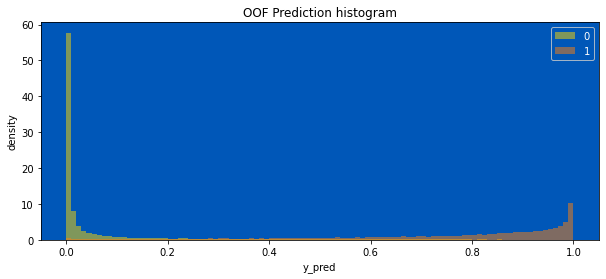

In [67]:
def sigmoid(log_odds):
    return 1 / (1 + np.exp(-log_odds))

plt.figure(figsize=(10, 4))
plt.hist(sigmoid(y_va_pred[y_va == 0]), bins=np.linspace(0, 1, 101),
         alpha=0.5, density=True, label='0')
plt.hist(sigmoid(y_va_pred[y_va == 1]), bins=np.linspace(0, 1, 101),
         alpha=0.5, density=True, label='1')
plt.xlabel('y_pred')
plt.ylabel('density')
plt.title('OOF Prediction histogram', color='k')
plt.legend()
plt.show()

# Calibration diagram

The calibration diagram shows how the model predicts the default probability of customers:

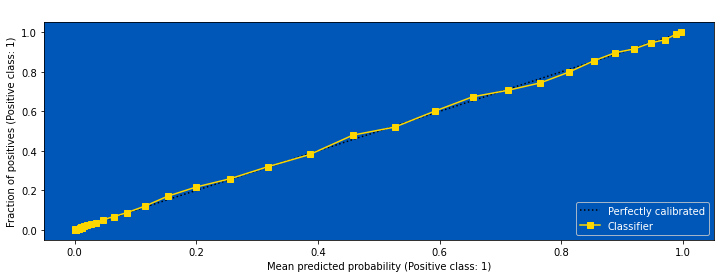

In [68]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, sigmoid(y_va_pred), n_bins=50,
                                    strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

# Submission

We submit the mean of the five predictions. As proposed by @lucasmorin, we [take the mean of the log odds](https://www.kaggle.com/competitions/amex-default-prediction/discussion/329103) rather than of the probabilities.

In [69]:
if INFERENCE:
    sub = pd.DataFrame({'customer_ID': test.index,
                        'prediction': np.mean(y_pred_list, axis=0)})
    sub.to_csv('submission.csv', index=False)
    display(sub)

,customer_ID,prediction
0,00000469ba478561f23a92a868bd366de6f6527a684c9a...,-3.927225
1,00001bf2e77ff879fab36aa4fac689b9ba411dae63ae39...,-7.309913
2,0000210045da4f81e5f122c6bde5c2a617d03eef67f82c...,-3.131304
3,00003b41e58ede33b8daf61ab56d9952f17c9ad1c3976c...,-1.514675
4,00004b22eaeeeb0ec976890c1d9bfc14fd9427e98c4ee9...,1.756631
...,...,...
924616,ffff952c631f2c911b8a2a8ca56ea6e656309a83d2f64c...,-4.875607
924617,ffffcf5df59e5e0bba2a5ac4578a34e2b5aa64a1546cd3...,1.078513
924618,ffffd61f098cc056dbd7d2a21380c4804bbfe60856f475...,-0.327318
924619,ffffddef1fc3643ea179c93245b68dca0f36941cd83977...,-0.923045


As a final check, we verify that the test prediction distribution equals the validation prediction distribution. 

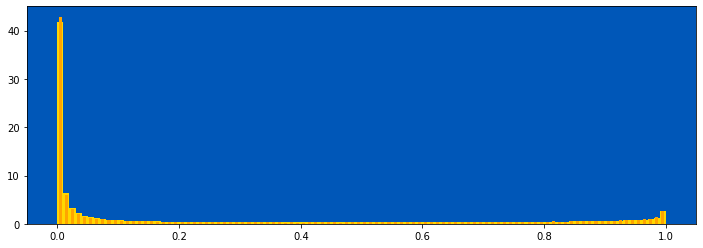

In [70]:
if INFERENCE:
    plt.figure(figsize=(12, 4))
    plt.hist(sigmoid(sub.prediction), bins=np.linspace(0, 1, 101), density=True)
    plt.hist(sigmoid(y_va_pred), bins=np.linspace(0, 1, 101), rwidth=0.5, color='orange', density=True)
    plt.show()